# General Imports

In [12]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%matplotlib inline

In [14]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from PIL import Image
from icecream import ic

In [15]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [16]:
from datasets import GtsrbModule

In [17]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.datamodules import STL10DataModule

In [18]:
from models import ResnetModule

In [19]:
from dropblock import DropBlock2D, LinearScheduler

In [20]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier
from ls_ood_detect_cea.metrics import get_ood_detector_results, plot_roc_ood_detector

# Datasets

## GTSRB-Normal

In [22]:
dataset_path = "/media/farnez/Data/DATASETS/gtsrb-data/"

In [23]:
gtsrb_normal_dm = GtsrbModule(img_size=(128, 128), data_path=dataset_path, batch_size=1, shuffle=False)

In [24]:
gtsrb_normal_dm.setup(stage='fit')
gtsrb_normal_dm.setup(stage='validate')
gtsrb_normal_dm.setup(stage='test')

In [25]:
gtsrb_ds_len = len(gtsrb_normal_dm.ds_gtsrb_train)
indices_train_dl = list(range(gtsrb_ds_len))
samples_size = 0.2 # of the dataset

random.seed(9290)
random.shuffle(indices_train_dl)

split = int(np.floor(gtsrb_ds_len * samples_size))
samples_idx = indices_train_dl[:split]
ic(len(samples_idx));

train_sampler = SubsetRandomSampler(samples_idx)

gtsrb_normal_dm.shuffle = False
gtsrb_normal_dm.ds_gtsrb_train_sampler = train_sampler

ic| len(samples_idx): 7120


In [26]:
gtsrb_normal_train_loader = gtsrb_normal_dm.train_dataloader()
gtsrb_normal_valid_loader = gtsrb_normal_dm.val_dataloader()
gtsrb_normal_test_loader = gtsrb_normal_dm.test_dataloader()
ic(len(gtsrb_normal_train_loader));
ic(len(gtsrb_normal_valid_loader));
ic(len(gtsrb_normal_test_loader));

ic| len(gtsrb_normal_train_loader): 7120
ic| len(gtsrb_normal_valid_loader): 3609
ic| len(gtsrb_normal_test_loader): 1273


In [72]:
dataiter = iter(gtsrb_normal_train_loader)

Right-of-way at the next intersection


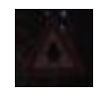

In [100]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
print(gtsrb_normal_dm.idx2label[lbl_np.item()])
gtsrb_normal_dm.unprocess_image(samp[0], plot=True)

In [24]:
ic(samp.shape)

ic| samp.shape: torch.Size([1, 3, 128, 128])


torch.Size([1, 3, 128, 128])

## GTSRB-Anomalies

In [23]:
dataset_path = "/media/farnez/Data/DATASETS/gtsrb-data/"

In [24]:
gtsrb_anomal_dm = GtsrbModule(img_size=(128, 128), data_path=dataset_path, batch_size=1, anomaly_transforms=True, shuffle=True)

In [25]:
gtsrb_anomal_dm.setup(stage='fit')
gtsrb_anomal_dm.setup(stage='validate')
gtsrb_anomal_dm.setup(stage='test')
# print(gtsrb_anomal_dm.ds_gtsrb_train)
# print(gtsrb_anomal_dm.ds_gtsrb_valid)
# print(gtsrb_anomal_dm.ds_gtsrb_test)

In [26]:
gtsrb_anomal_train_loader = gtsrb_anomal_dm.train_dataloader()
gtsrb_anomal_valid_loader = gtsrb_anomal_dm.val_dataloader()
gtsrb_anomal_test_loader = gtsrb_anomal_dm.test_dataloader()
ic(len(gtsrb_anomal_train_loader));
ic(len(gtsrb_anomal_valid_loader));
ic(len(gtsrb_anomal_test_loader));

ic| len(gtsrb_anomal_train_loader): 35600
ic| len(gtsrb_anomal_valid_loader): 3609
ic| len(gtsrb_anomal_test_loader): 1273


In [27]:
dataiter_anomal = iter(gtsrb_anomal_train_loader)

Speed limit (30km/h)


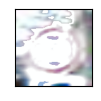

In [51]:
samp, lbl = dataiter_anomal.next()
lbl_np = lbl[0].cpu().numpy()
print(gtsrb_anomal_dm.idx2label[lbl_np.item()])
gtsrb_anomal_dm.unprocess_image(samp[0], plot=True)

In [90]:
gtsrb_anomal_dm.anomaly_transforms

True

In [91]:
samp.shape

torch.Size([1, 3, 128, 128])

## CIFAR-10 OoD

In [52]:
cifar10_data_dir = "/media/farnez/Data/DATASETS/cifar-10/"

In [53]:
cifar10_dm = CIFAR10DataModule(data_dir=cifar10_data_dir,
                               val_split=0.2,
                               num_workers=10,
                               normalize=True,
                               batch_size=1,
                               seed=10,
                               drop_last=True,
                               shuffle=True)

# cifar10_transforms = transform_lib.Compose([
#     transform_lib.Resize((64, 64)),
#     transform_lib.ToTensor(),
#     transform_lib.Normalize(
#         mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
#         std=[x / 255.0 for x in [63.0, 62.1, 66.7]]
#     )
# ])
cifar10_transforms = transform_lib.Compose([
    transform_lib.Resize((128, 128)),
    transform_lib.ToTensor(),
    transform_lib.Normalize(
        mean=[0.3337, 0.3064, 0.3171],
        std=[0.2672, 0.2564, 0.2629]
    )
])

cifar10_dm.train_transforms = cifar10_transforms
cifar10_dm.test_transforms = cifar10_transforms
cifar10_dm.val_transforms  = cifar10_transforms

In [102]:
cifar10_dm.prepare_data()

Files already downloaded and verified
Files already downloaded and verified


In [54]:
cifar10_dm.setup(stage='fit')
cifar10_dm.setup(stage='test')

In [55]:
cifar10_train_loader = cifar10_dm.train_dataloader()
cifar10_valid_loader = cifar10_dm.val_dataloader()
cifar10_test_loader = cifar10_dm.test_dataloader()
ic(len(cifar10_train_loader));
ic(len(cifar10_valid_loader));
ic(len(cifar10_test_loader));

ic| len(cifar10_train_loader): 40000
ic| len(cifar10_valid_loader): 10000
ic| len(cifar10_test_loader): 10000


In [56]:
def unprocess_cifar10_image(im,
                            norm_mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                            norm_std=[x / 255.0 for x in [63.0, 62.1, 66.7]], 
                            plot=False):
    # im = im.squeeze().numpy().transpose((1, 2, 0))
    norm_mean = np.array(norm_mean)
    norm_std = np.array(norm_std)
    im = im.squeeze().numpy().transpose((1, 2, 0))
    im = norm_std * im + norm_mean
    im = np.clip(im, 0, 1)
    im = im * 255
    im = Image.fromarray(im.astype(np.uint8))

    if plot:
        plt.rcParams['figure.figsize'] = [2.54/2.54, 2.54/2.54]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        return im

In [57]:
dataiter = iter(cifar10_train_loader)

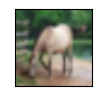

In [75]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
unprocess_cifar10_image(samp[0], norm_mean=[0.3337, 0.3064, 0.3171], norm_std=[0.2672, 0.2564, 0.2629], plot=True)

In [76]:
samp.shape

torch.Size([1, 3, 128, 128])

## STL-10 OoD

In [77]:
stl10_data_dir = "/media/farnez/Data/DATASETS/stl-10/"

In [78]:
stl10_dm = STL10DataModule(data_dir=stl10_data_dir,
                           train_val_split=3000,
                           num_workers=10,
                           batch_size=1,
                           seed=10,
                           drop_last=True,
                           shuffle=True)

# stl10_transforms = transform_lib.Compose([
#     transform_lib.Resize((32, 32)),
#     transform_lib.ToTensor(),
#     transform_lib.Normalize(
#         mean=(0.43, 0.42, 0.39),
#         std=(0.27, 0.26, 0.27)
#     )
# ])

stl10_transforms = transform_lib.Compose([
    transform_lib.Resize((128, 128)),
    transform_lib.ToTensor(),
    transform_lib.Normalize(
        mean=(0.3337, 0.3064, 0.3171),
        std=(0.2672, 0.2564, 0.2629)
    )
])

stl10_dm.train_transforms = stl10_transforms
stl10_dm.test_transforms = stl10_transforms
stl10_dm.val_transforms  = stl10_transforms

In [132]:
stl10_dm.prepare_data()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [79]:
stl10_train_loader = stl10_dm.train_dataloader_labeled()
stl10_valid_loader = stl10_dm.val_dataloader_labeled()
stl10_test_loader = stl10_dm.test_dataloader()
ic(len(stl10_train_loader));
ic(len(stl10_valid_loader));
ic(len(stl10_test_loader));

ic| len(stl10_train_loader): 2000
ic| len(stl10_valid_loader): 3000
ic| len(stl10_test_loader): 8000


In [80]:
def unprocess_stl10_image(im,
                          norm_mean=[0.43, 0.42, 0.39],
                          norm_std=[0.27, 0.26, 0.27], 
                          plot=False):
    # im = im.squeeze().numpy().transpose((1, 2, 0))
    norm_mean = np.array(norm_mean)
    norm_std = np.array(norm_std)
    im = im.squeeze().numpy().transpose((1, 2, 0))
    im = norm_std * im + norm_mean
    im = np.clip(im, 0, 1)
    im = im * 255
    im = Image.fromarray(im.astype(np.uint8))

    if plot:
        plt.rcParams['figure.figsize'] = [2.54/2.54, 2.54/2.54]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        return im

In [81]:
dataiter = iter(stl10_train_loader)

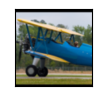

In [84]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
unprocess_stl10_image(samp[0], norm_mean=[0.3337, 0.3064, 0.3171], norm_std=[0.2672, 0.2564, 0.2629], plot=True)

# GTSRB ResNet18 Classifier

In [27]:
# gtsrb_model_path = "/home/farnez/Projects/GTSRB-Classifier/lightning_logs/2023-05-10_19-23-50/last.ckpt"
# gtsrb_model_path = "/home/farnez/Projects/GTSRB-Classifier/lightning_logs/2023-05-13_16-10-19/epoch=1033-step=144760.ckpt"
gtsrb_model_path = "/home/farnez/Projects/GTSRB-Classifier/lightning_logs/2023-05-17_00-13-13/last.ckpt"
gtsrb_model = ResnetModule.load_from_checkpoint(checkpoint_path=gtsrb_model_path)

In [28]:
gtsrb_model;

In [29]:
gtsrb_model.eval();

In [53]:
gtsrb_model_sn_path = "/home/farnez/Projects/GTSRB-Classifier/lightning_logs/2023-05-14_03-11-13/last.ckpt"
gtsrb_model = ResnetModule.load_from_checkpoint(checkpoint_path=gtsrb_model_sn_path)

In [57]:
gtsrb_model;

In [58]:
gtsrb_model.eval();

# Add Hook

We add 2 Hooks:

1. In the dropblock2d layer (after applying dropout to the)
2. In the fc (after applying a linear transformation to the output of the dropblock2d layer)

In [30]:
ic(gtsrb_model.model.dropblock2d_layer);
ic(gtsrb_model.model.dropblock2d_layer.drop_prob);
ic(gtsrb_model.model.dropblock2d_layer.block_size);
ic(gtsrb_model.model.dropblock2d_layer.training);
ic("===========================")
ic(gtsrb_model.model.dropout_layer);
ic(gtsrb_model.model.dropout_layer.p);
ic(gtsrb_model.model.dropout_layer.training);

ic| gtsrb_model.model.dropblock2d_layer: DropBlock2D()
ic| gtsrb_model.model.dropblock2d_layer.drop_prob: 0.3
ic| gtsrb_model.model.dropblock2d_layer.block_size: 4
ic| gtsrb_model.model.dropblock2d_layer.training: False
ic| '==========================='
ic| gtsrb_model.model.dropout_layer: Dropout(p=0.3, inplace=False)
ic| gtsrb_model.model.dropout_layer.p: 0.3
ic| gtsrb_model.model.dropout_layer.training: False


## Hook DropBlock2D Layer

In [31]:
gtsrb_model_dropblock2d_layer_hook = Hook(gtsrb_model.model.dropblock2d_layer)

In [32]:
ic(gtsrb_model.model.dropblock2d_layer._forward_hooks);

ic| gtsrb_model.model.dropblock2d_layer._forward_hooks: OrderedDict([(2,
                                                                      <bound method Hook.hook_fn of <ls_ood_detect_cea.uncertainty_estimation.Hook object at 0x7fe5984a6110>>)])


# Get Monte-Carlo Samples

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [34]:
# Monte Carlo Dropout - Enable Dropout @ Test Time!
def resnet18_enable_dropblock2d_test(m):
    if type(m) == DropBlock2D:
        m.train()

In [35]:
mc_samples = 16

In [36]:
gtsrb_model.to(device);
gtsrb_model.eval(); 
gtsrb_model.apply(resnet18_enable_dropblock2d_test); # enable dropout

In [37]:
ic(gtsrb_model.model.dropblock2d_layer);
ic(gtsrb_model.model.dropblock2d_layer.drop_prob);
ic(gtsrb_model.model.dropblock2d_layer.block_size);
ic(gtsrb_model.model.dropblock2d_layer.training);
ic("=======")
ic(gtsrb_model.model.dropout_layer);
ic(gtsrb_model.model.dropout_layer.p);
ic(gtsrb_model.model.dropout_layer.training);

ic| gtsrb_model.model.dropblock2d_layer: DropBlock2D()
ic| gtsrb_model.model.dropblock2d_layer.drop_prob: 0.3
ic| gtsrb_model.model.dropblock2d_layer.block_size: 4
ic| gtsrb_model.model.dropblock2d_layer.training: True
ic| '======='
ic| gtsrb_model.model.dropout_layer: Dropout(p=0.3, inplace=False)
ic| gtsrb_model.model.dropout_layer.p: 0.3
ic| gtsrb_model.model.dropout_layer.training: False


In [38]:
gtsrb_normal_valid_loader.dataset

Dataset ImageFolder
    Number of datapoints: 3609
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/val_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7fe598dc4350>

In [39]:
gtsrb_normal_test_loader.dataset

Dataset ImageFolder
    Number of datapoints: 1273
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/test_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7fe598dc4590>

In [56]:
gtsrb_anomal_valid_loader.dataset

Dataset ImageFolder
    Number of datapoints: 3609
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/val_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7f96fc86aa90>

In [57]:
gtsrb_anomal_test_loader.dataset

Dataset ImageFolder
    Number of datapoints: 1273
    Root location: /media/farnez/Data/DATASETS/gtsrb-data/test_images/
    StandardTransform
Transform: <datasets.gtsrb.Transforms object at 0x7f96fc332f50>

In [59]:
cifar10_valid_loader.dataset.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /media/farnez/Data/DATASETS/cifar-10/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4913725490196078, 0.4823529411764706, 0.4466666666666667], std=[0.24705882352941178, 0.24352941176470588, 0.2615686274509804])
           )

In [69]:
cifar10_test_loader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /media/farnez/Data/DATASETS/cifar-10/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4913725490196078, 0.4823529411764706, 0.4466666666666667], std=[0.24705882352941178, 0.24352941176470588, 0.2615686274509804])
           )

In [64]:
stl10_valid_loader.dataset.dataset

Dataset STL10
    Number of datapoints: 5000
    Root location: /media/farnez/Data/DATASETS/stl-10/
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.43, 0.42, 0.39), std=(0.27, 0.26, 0.27))
           )

In [127]:
stl10_test_loader.dataset

Dataset STL10
    Number of datapoints: 8000
    Root location: /media/farnez/Data/DATASETS/stl-10/
    Split: test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.43, 0.42, 0.39), std=(0.27, 0.26, 0.27))
           )

In [40]:
gtsrb_resnet_gtsrb_normal_train_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                                gtsrb_normal_train_loader,
                                                                                mc_samples,
                                                                                gtsrb_model_dropblock2d_layer_hook,
                                                                                get_2d_rep_mean=True)

In [41]:
gtsrb_resnet_gtsrb_normal_train_16mc_samples.shape

torch.Size([113920, 128])

In [96]:
gtsrb_resnet_gtsrb_normal_valid_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                                gtsrb_normal_valid_loader,
                                                                                mc_samples,
                                                                                gtsrb_model_dropblock2d_layer_hook,
                                                                                get_2d_rep_mean=True)

# gtsrb_resnet_sn_gtsrb_normal_valid_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
#                                                                                 gtsrb_normal_valid_loader,
#                                                                                 mc_samples,
#                                                                                 gtsrb_model_dropblock2d_layer_hook,
#                                                                                 get_2d_rep_mean=True)

In [97]:
gtsrb_resnet_gtsrb_normal_test_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                               gtsrb_normal_test_loader,
                                                                               mc_samples,
                                                                               gtsrb_model_dropblock2d_layer_hook,
                                                                               get_2d_rep_mean=True)

# gtsrb_resnet_sn_gtsrb_normal_test_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
#                                                                                gtsrb_normal_test_loader,
#                                                                                mc_samples,
#                                                                                gtsrb_model_dropblock2d_layer_hook,
#                                                                                get_2d_rep_mean=True)

In [98]:
gtsrb_resnet_gtsrb_anomal_valid_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                                gtsrb_anomal_valid_loader,
                                                                                mc_samples,
                                                                                gtsrb_model_dropblock2d_layer_hook,
                                                                                get_2d_rep_mean=True)

In [99]:
gtsrb_resnet_gtsrb_anomal_test_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                               gtsrb_anomal_test_loader,
                                                                               mc_samples,
                                                                               gtsrb_model_dropblock2d_layer_hook,
                                                                               get_2d_rep_mean=True)

In [100]:
gtsrb_resnet_cifar10_valid_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                           cifar10_valid_loader,
                                                                           mc_samples,
                                                                           gtsrb_model_dropblock2d_layer_hook,
                                                                           get_2d_rep_mean=True)

# gtsrb_resnet_sn_cifar10_valid_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
#                                                                            cifar10_valid_loader,
#                                                                            mc_samples,
#                                                                            gtsrb_model_dropblock2d_layer_hook,
#                                                                            get_2d_rep_mean=True)

In [101]:
gtsrb_resnet_cifar10_test_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                          cifar10_test_loader,
                                                                          mc_samples,
                                                                          gtsrb_model_dropblock2d_layer_hook,
                                                                          get_2d_rep_mean=True)

# gtsrb_resnet_sn_cifar10_test_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
#                                                                           cifar10_test_loader,
#                                                                           mc_samples,
#                                                                           gtsrb_model_dropblock2d_layer_hook,
#                                                                           get_2d_rep_mean=True)

In [102]:
gtsrb_resnet_stl10_valid_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                         stl10_valid_loader,
                                                                         mc_samples,
                                                                         gtsrb_model_dropblock2d_layer_hook,
                                                                         get_2d_rep_mean=True)

# gtsrb_resnet_sn_stl10_valid_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
#                                                                          stl10_valid_loader,
#                                                                          mc_samples,
#                                                                          gtsrb_model_dropblock2d_layer_hook,
#                                                                          get_2d_rep_mean=True)

In [103]:
gtsrb_resnet_stl10_test_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                        stl10_test_loader,
                                                                        mc_samples,
                                                                        gtsrb_model_dropblock2d_layer_hook,
                                                                        get_2d_rep_mean=True)

# gtsrb_resnet_sn_stl10_test_32mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
#                                                                         stl10_test_loader,
#                                                                         mc_samples,
#                                                                         gtsrb_model_dropblock2d_layer_hook,
#                                                                         get_2d_rep_mean=True)

In [42]:
torch.save(gtsrb_resnet_gtsrb_normal_train_16mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_gtsrb_normal_train_16mc_samples.pt')

In [104]:
torch.save(gtsrb_resnet_gtsrb_normal_valid_16mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_gtsrb_normal_valid_16mc_samples.pt')
torch.save(gtsrb_resnet_gtsrb_normal_test_16mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_gtsrb_normal_test_16mc_samples.pt')

# torch.save(gtsrb_resnet_sn_gtsrb_normal_valid_32mc_samples,
#            '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_sn_gtsrb_normal_valid_16mc_samples.pt')
# torch.save(gtsrb_resnet_sn_gtsrb_normal_test_32mc_samples,
#            '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_sn_gtsrb_normal_test_16mc_samples.pt')

In [105]:
torch.save(gtsrb_resnet_gtsrb_anomal_valid_16mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_gtsrb_anomal_valid_16mc_samples.pt')
torch.save(gtsrb_resnet_gtsrb_anomal_test_16mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_gtsrb_anomal_test_16mc_samples.pt')

In [106]:
torch.save(gtsrb_resnet_cifar10_valid_16mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_cifar10_valid_16mc_samples.pt')
torch.save(gtsrb_resnet_cifar10_test_16mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_cifar10_test_16mc_samples.pt')

# torch.save(gtsrb_resnet_sn_cifar10_valid_32mc_samples,
#            '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_sn_cifar10_valid_16mc_samples.pt')
# torch.save(gtsrb_resnet_sn_cifar10_test_32mc_samples,
#            '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_sn_cifar10_test_16mc_samples.pt')

In [107]:
torch.save(gtsrb_resnet_stl10_valid_16mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_stl10_valid_16mc_samples.pt')
torch.save(gtsrb_resnet_stl10_test_16mc_samples,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_stl10_test_16mc_samples.pt')

# torch.save(gtsrb_resnet_sn_stl10_valid_32mc_samples,
#            '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_sn_stl10_valid_16mc_samples.pt')
# torch.save(gtsrb_resnet_sn_stl10_test_32mc_samples,
#            '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/mc_samples/gtsrb_resnet_sn_stl10_test_16mc_samples.pt')

# Get Entropy

In [43]:
_, gtsrb_rn18_h_z_gtsrb_normal_train_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_train_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (7120, 1)
ic| dl_h_z_samples_np.shape: (7120, 128)


In [108]:
_, gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_valid_16mc_samples, mcd_samples_nro=mc_samples)
# _, gtsrb_rn18_sn_h_z_gtsrb_normal_valid_samples_np = get_dl_h_z(gtsrb_resnet_sn_gtsrb_normal_valid_32mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (3609, 1)
ic| dl_h_z_samples_np.shape: (3609, 128)


In [109]:
_, gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_test_16mc_samples, mcd_samples_nro=mc_samples)
# _, gtsrb_rn18_sn_h_z_gtsrb_normal_test_samples_np = get_dl_h_z(gtsrb_resnet_sn_gtsrb_normal_test_32mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (1273, 1)
ic| dl_h_z_samples_np.shape: (1273, 128)


In [110]:
_, gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_anomal_valid_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (3609, 1)
ic| dl_h_z_samples_np.shape: (3609, 128)


In [111]:
_, gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_anomal_test_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (1273, 1)
ic| dl_h_z_samples_np.shape: (1273, 128)


In [112]:
_, gtsrb_rn18_h_z_cifar10_valid_samples_np = get_dl_h_z(gtsrb_resnet_cifar10_valid_16mc_samples, mcd_samples_nro=mc_samples)
# _, gtsrb_rn18_sn_h_z_cifar10_valid_samples_np = get_dl_h_z(gtsrb_resnet_sn_cifar10_valid_32mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (10000, 1)
ic| dl_h_z_samples_np.shape: (10000, 128)


In [113]:
_, gtsrb_rn18_h_z_cifar10_test_samples_np = get_dl_h_z(gtsrb_resnet_cifar10_test_16mc_samples, mcd_samples_nro=mc_samples)
# _, gtsrb_rn18_sn_h_z_cifar10_test_samples_np = get_dl_h_z(gtsrb_resnet_sn_cifar10_test_32mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (10000, 1)
ic| dl_h_z_samples_np.shape: (10000, 128)


In [114]:
_, gtsrb_rn18_h_z_stl10_valid_samples_np = get_dl_h_z(gtsrb_resnet_stl10_valid_16mc_samples, mcd_samples_nro=mc_samples)
# _, gtsrb_rn18_sn_h_z_stl10_valid_samples_np = get_dl_h_z(gtsrb_resnet_sn_stl10_valid_32mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (3000, 1)
ic| dl_h_z_samples_np.shape: (3000, 128)


In [115]:
_, gtsrb_rn18_h_z_stl10_test_samples_np = get_dl_h_z(gtsrb_resnet_stl10_test_16mc_samples, mcd_samples_nro=mc_samples)
# _, gtsrb_rn18_sn_h_z_stl10_test_samples_np = get_dl_h_z(gtsrb_resnet_sn_stl10_test_32mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (8000, 1)
ic| dl_h_z_samples_np.shape: (8000, 128)


In [ ]:
np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_normal_train_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_train_samples_np)

In [120]:
np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_normal_test_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_test_samples_np)

# np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_sn_h_z_gtsrb_normal_valid_samples_np',
#         gtsrb_rn18_sn_h_z_gtsrb_normal_valid_samples_np)

# np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_sn_h_z_gtsrb_normal_test_samples_np',
#         gtsrb_rn18_sn_h_z_gtsrb_normal_test_samples_np)

In [121]:
np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np',
        gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np',
        gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np)

In [122]:
np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_cifar10_valid_samples_np',
        gtsrb_rn18_h_z_cifar10_valid_samples_np)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_cifar10_test_samples_np',
        gtsrb_rn18_h_z_cifar10_test_samples_np)

# np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_sn_h_z_cifar10_valid_samples_np',
#         gtsrb_rn18_sn_h_z_cifar10_valid_samples_np)

# np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_sn_h_z_cifar10_test_samples_np',
#         gtsrb_rn18_sn_h_z_cifar10_test_samples_np)

In [123]:
np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_stl10_valid_samples_np',
        gtsrb_rn18_h_z_stl10_valid_samples_np)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_stl10_test_samples_np',
        gtsrb_rn18_h_z_stl10_test_samples_np)

# np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_sn_h_z_stl10_valid_samples_np',
#         gtsrb_rn18_sn_h_z_stl10_valid_samples_np)

# np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_sn_h_z_stl10_test_samples_np',
#         gtsrb_rn18_sn_h_z_stl10_test_samples_np)

# Load Entropy Values

In [12]:
gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.npy')

gtsrb_rn18_h_z_cifar10_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_cifar10_valid_samples_np.npy')

gtsrb_rn18_h_z_cifar10_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_cifar10_test_samples_np.npy')

gtsrb_rn18_h_z_stl10_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_stl10_valid_samples_np.npy')

gtsrb_rn18_h_z_stl10_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_h_z_stl10_test_samples_np.npy')

In [13]:
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);


ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 128)


In [10]:
gtsrb_rn18_sn_h_z_gtsrb_normal_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_sn_h_z_gtsrb_normal_valid_samples_np.npy')
gtsrb_rn18_sn_h_z_gtsrb_normal_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_sn_h_z_gtsrb_normal_test_samples_np.npy')

gtsrb_rn18_sn_h_z_cifar10_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_sn_h_z_cifar10_valid_samples_np.npy')
gtsrb_rn18_sn_h_z_cifar10_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_sn_h_z_cifar10_test_samples_np.npy')

gtsrb_rn18_sn_h_z_stl10_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_sn_h_z_stl10_valid_samples_np.npy')
gtsrb_rn18_sn_h_z_stl10_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_sn_h_z_stl10_test_samples_np.npy')

In [27]:
gtsrb_rn18_h_z_cifar10_valid_samples_np.shape

(10000, 128)

In [26]:
gtsrb_rn18_h_z_cifar10_test_samples_np.shape

(10000, 128)

In [30]:
idx_cifar10_valid = np.random.choice(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape[0], 3000, replace=False)
idx_cifar10_test = np.random.choice(gtsrb_rn18_h_z_cifar10_test_samples_np.shape[0], 3000, replace=False)

In [31]:
gtsrb_rn18_h_z_cifar10_valid_samples_np = gtsrb_rn18_h_z_cifar10_valid_samples_np[idx_cifar10_valid]
gtsrb_rn18_h_z_cifar10_test_samples_np = gtsrb_rn18_h_z_cifar10_test_samples_np[idx_cifar10_test]

ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);

ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (3000, 128)


# Entropy 2D Projection

(7218, 128)
(7218, 1)
(7218, 2)


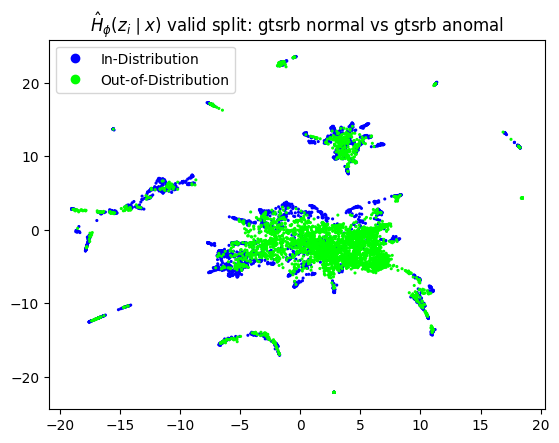

In [12]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                    gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid split: gtsrb normal vs gtsrb anomal")

(2546, 128)
(2546, 1)
(2546, 2)


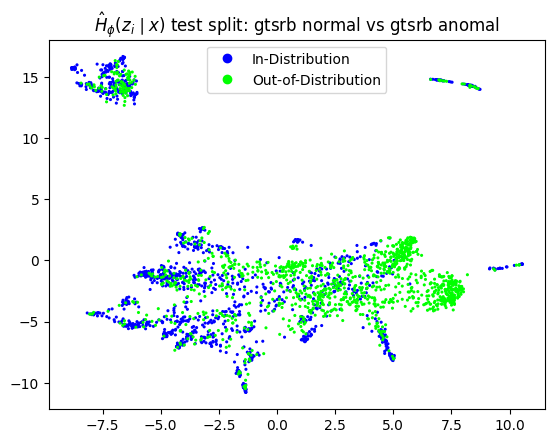

In [13]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np,
                    gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np,
                    neighbors=14,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test split: gtsrb normal vs gtsrb anomal")

(6609, 128)
(6609, 1)
(6609, 2)


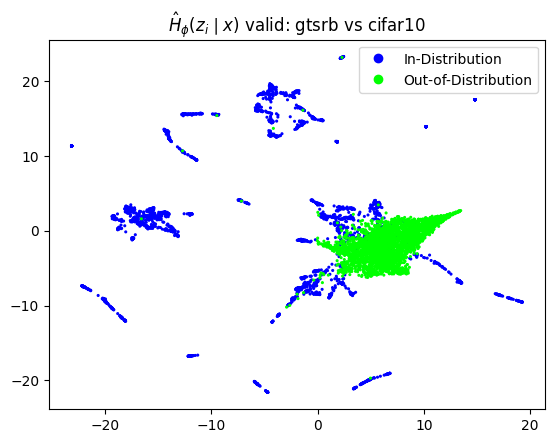

In [32]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                    gtsrb_rn18_h_z_cifar10_valid_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid: gtsrb vs cifar10")
# plot_samples_pacmap(gtsrb_rn18_sn_h_z_gtsrb_normal_valid_samples_np,
#                     gtsrb_rn18_sn_h_z_cifar10_valid_samples_np,
#                     neighbors=10,
#                     title="$\hat{H}_{\phi}(z_i \mid x)$ valid: gtsrb vs cifar10")

(6609, 128)
(6609, 1)
(6609, 2)


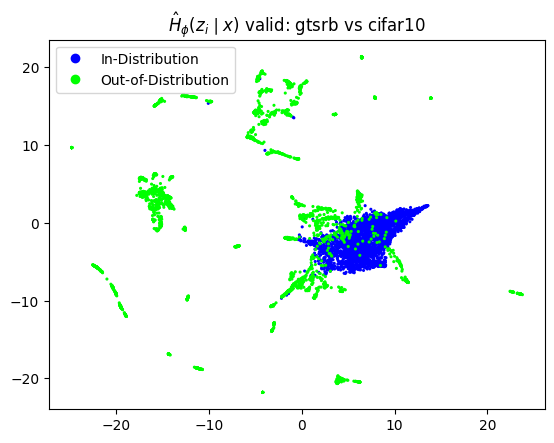

In [33]:
plot_samples_pacmap(gtsrb_rn18_h_z_cifar10_valid_samples_np,
                    gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid: gtsrb vs cifar10")

(4273, 128)
(4273, 1)
(4273, 2)


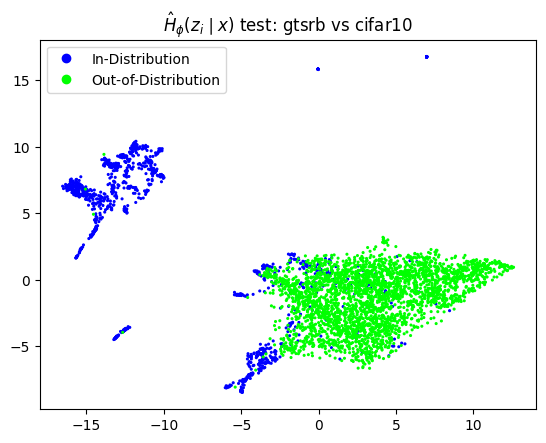

In [35]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np,
                    gtsrb_rn18_h_z_cifar10_test_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test: gtsrb vs cifar10")
# plot_samples_pacmap(gtsrb_rn18_sn_h_z_gtsrb_normal_test_samples_np,
#                     gtsrb_rn18_sn_h_z_cifar10_test_samples_np,
#                     neighbors=10,
#                     title="$\hat{H}_{\phi}(z_i \mid x)$ test: gtsrb vs cifar10")

(4273, 128)
(4273, 1)
(4273, 2)


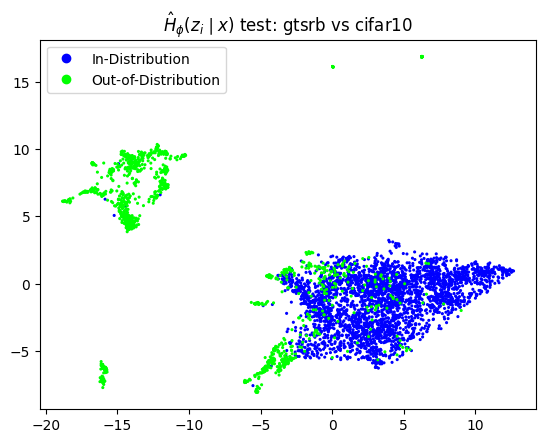

In [36]:
plot_samples_pacmap(gtsrb_rn18_h_z_cifar10_test_samples_np,
                    gtsrb_rn18_h_z_gtsrb_normal_test_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test: gtsrb vs cifar10")

(6609, 128)
(6609, 1)
(6609, 2)


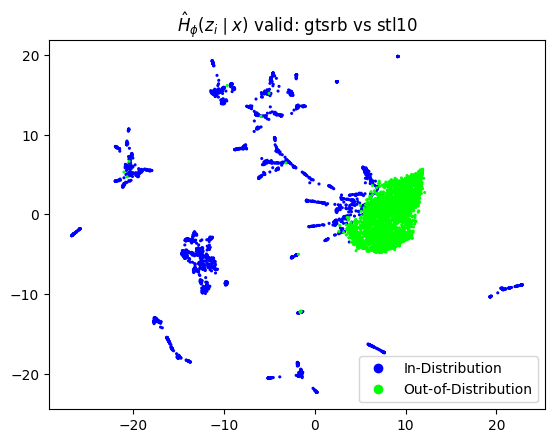

In [21]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                    gtsrb_rn18_h_z_stl10_valid_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid: gtsrb vs stl10")

# plot_samples_pacmap(gtsrb_rn18_sn_h_z_gtsrb_normal_valid_samples_np,
#                     gtsrb_rn18_sn_h_z_stl10_valid_samples_np,
#                     neighbors=10,
#                     title="$\hat{H}_{\phi}(z_i \mid x)$ valid: gtsrb vs stl10")

(6609, 128)
(6609, 1)
(6609, 2)


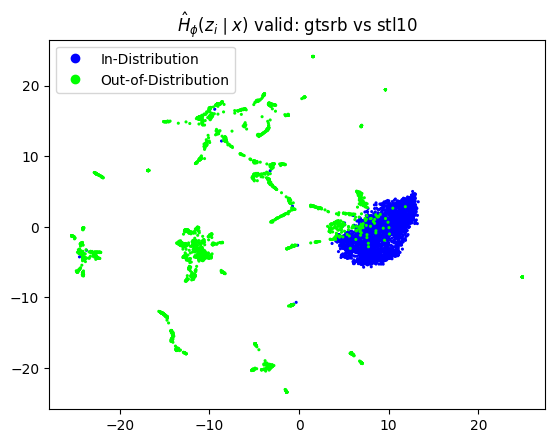

In [22]:
plot_samples_pacmap(gtsrb_rn18_h_z_stl10_valid_samples_np,
                    gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid: gtsrb vs stl10")

(9273, 128)
(9273, 1)
(9273, 2)


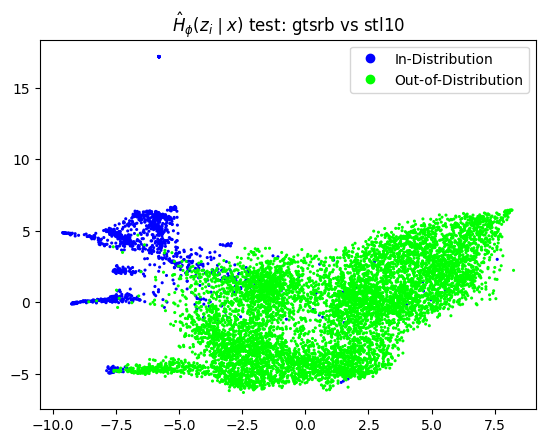

In [37]:
plot_samples_pacmap(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np,
                    gtsrb_rn18_h_z_stl10_test_samples_np,
                    neighbors=16,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test: gtsrb vs stl10")

# plot_samples_pacmap(gtsrb_rn18_sn_h_z_gtsrb_normal_test_samples_np,
#                     gtsrb_rn18_sn_h_z_stl10_test_samples_np,
#                     neighbors=16,
#                     title="$\hat{H}_{\phi}(z_i \mid x)$ test: gtsrb vs stl10")

(9273, 128)
(9273, 1)
(9273, 2)


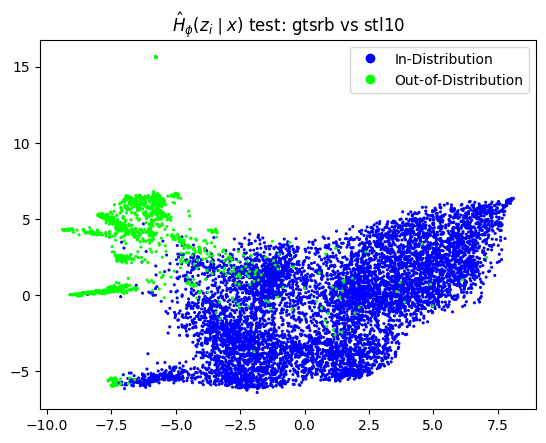

In [38]:
plot_samples_pacmap(gtsrb_rn18_h_z_stl10_test_samples_np,
                    gtsrb_rn18_h_z_gtsrb_normal_test_samples_np,
                    neighbors=16,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test: gtsrb vs stl10")

# Dimensionality Reduction

In [14]:
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 128)


In [15]:
import pacmap
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_ds_split
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_transform

In [16]:
from sklearn.neighbors import KernelDensity

## Using a single PCA transform referece

In [17]:
pca_h_z_gtsrb_normal_valid_samples, pca_tr = apply_pca_ds_split(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np, 16)
pca_h_z_gtsrb_normal_test_samples = apply_pca_transform(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np, pca_tr)
pca_h_z_stl10_valid_samples = apply_pca_transform(gtsrb_rn18_h_z_stl10_valid_samples_np, pca_tr)
pca_h_z_stl10_test_samples = apply_pca_transform(gtsrb_rn18_h_z_stl10_test_samples_np, pca_tr)
pca_h_z_cifar10_valid_samples = apply_pca_transform(gtsrb_rn18_h_z_cifar10_valid_samples_np, pca_tr)
pca_h_z_cifar10_test_samples = apply_pca_transform(gtsrb_rn18_h_z_cifar10_test_samples_np, pca_tr)

In [18]:
ic(pca_h_z_gtsrb_normal_valid_samples.shape);
ic(pca_h_z_stl10_valid_samples.shape);

ic| pca_h_z_gtsrb_normal_valid_samples.shape: (3609, 16)
ic| pca_h_z_stl10_valid_samples.shape: (3000, 16)


(11000, 16)
(11000, 1)
(11000, 2)


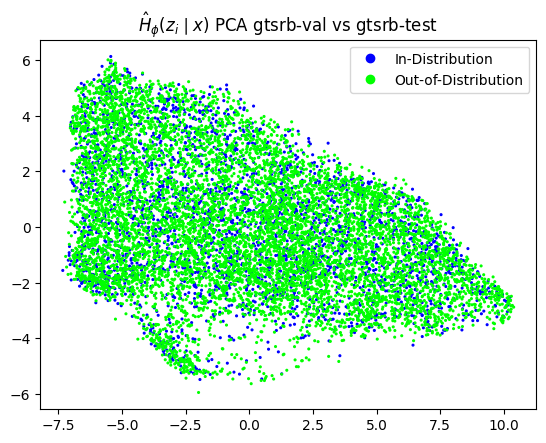

In [19]:
plot_samples_pacmap(pca_h_z_stl10_valid_samples,
                    pca_h_z_stl10_test_samples,
                    neighbors=16,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ PCA gtsrb-val vs gtsrb-test")

(6609, 16)
(6609, 1)
(6609, 2)


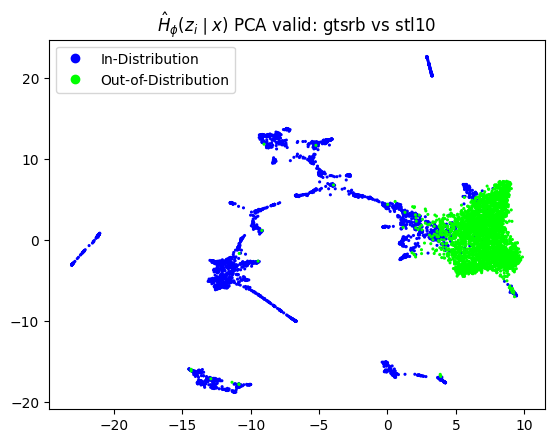

In [20]:
plot_samples_pacmap(pca_h_z_gtsrb_normal_valid_samples,
                    pca_h_z_stl10_valid_samples,
                    neighbors=16,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ PCA valid: gtsrb vs stl10")

In [21]:
def samples_pacmap(samples_ind: np.ndarray,
                   test_samples_1: np.ndarray,
                   test_samples_2: np.ndarray,
                   test_samples_3: np.ndarray,
                   neighbors: int = 25) -> None:

    samples_concat = np.concatenate((samples_ind, test_samples_1, test_samples_2, test_samples_3))
    label_normal = np.zeros((samples_ind.shape[0], 1))
    label_test_1 = np.ones((test_samples_1.shape[0], 1))
    label_test_2 = np.ones((test_samples_2.shape[0], 1)) * 2
    label_test_3 = np.ones((test_samples_3.shape[0], 1)) * 3
    labels = np.concatenate((label_normal, label_test_1, label_test_2, label_test_3))
    print(samples_concat.shape)
    print(labels.shape)
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=neighbors, MN_ratio=0.5, FP_ratio=2.0)
    samples_transformed = embedding.fit_transform(samples_concat, init="pca")
    return samples_transformed, labels

In [22]:
samples_transformed, labels = samples_pacmap(pca_h_z_gtsrb_normal_valid_samples, 
                                             pca_h_z_gtsrb_normal_valid_samples,
                                             pca_h_z_stl10_valid_samples,
                                             pca_h_z_cifar10_valid_samples,
                                            neighbors=16)

(20218, 16)
(20218, 1)


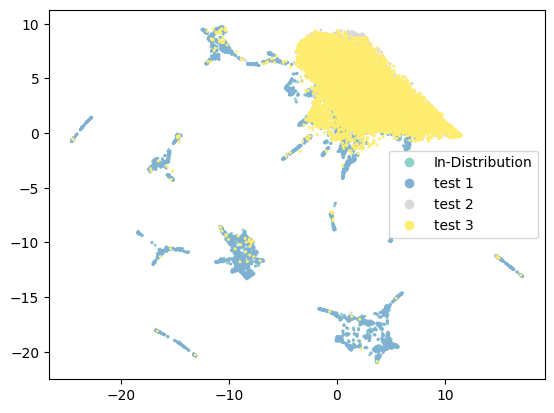

In [23]:
scatter = plt.scatter(samples_transformed[:, 0], samples_transformed[:, 1], cmap="Set3", c=labels, s=1.5)
# plt.title(title)
plt.legend(handles=scatter.legend_elements()[0], labels=["In-Distribution", "test 1", "test 2", "test 3"])
plt.show()

## Using two independent PCA transforms

In [20]:
pca_h_z_gtsrb_normal_valid_samples, pca_tr = apply_pca_ds_split(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np, 16)
pca_h_z_stl10_valid_samples, pca_tr = apply_pca_ds_split(gtsrb_rn18_h_z_stl10_valid_samples_np, 16)

(6609, 16)
(6609, 1)
(6609, 2)


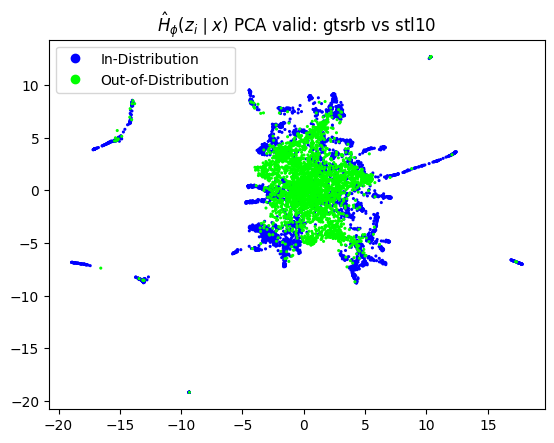

In [21]:
plot_samples_pacmap(pca_h_z_gtsrb_normal_valid_samples,
                    pca_h_z_stl10_valid_samples,
                    neighbors=16,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ PCA valid: gtsrb vs stl10")

# Build OoD Detector

In [24]:
from sklearn.neighbors import KernelDensity

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [26]:
ic(pca_h_z_gtsrb_normal_valid_samples.shape)
ic(pca_h_z_gtsrb_normal_test_samples.shape)
ic(pca_h_z_stl10_valid_samples.shape)
ic(pca_h_z_stl10_test_samples.shape)
ic(pca_h_z_cifar10_valid_samples.shape)
ic(pca_h_z_cifar10_test_samples.shape)

ic| pca_h_z_gtsrb_normal_valid_samples.shape: (3609, 16)
ic| pca_h_z_gtsrb_normal_test_samples.shape: (1273, 16)
ic| pca_h_z_stl10_valid_samples.shape: (3000, 16)
ic| pca_h_z_stl10_test_samples.shape: (8000, 16)
ic| pca_h_z_cifar10_valid_samples.shape: (10000, 16)
ic| pca_h_z_cifar10_test_samples.shape: (10000, 16)


(10000, 16)

In [27]:
def GDE_fit( train_embeds, save_path = None):
        GDE = KernelDensity().fit(train_embeds)
        return GDE

In [28]:
def GDE_scores(embeds, GDE):
        scores = GDE.score_samples(embeds)
        norm = np.linalg.norm(-scores)
        return -scores/norm

In [29]:
GDE = GDE_fit(pca_h_z_gtsrb_normal_valid_samples)

In [30]:
score_gtsrb_test = GDE_scores(pca_h_z_gtsrb_normal_test_samples, GDE)
score_stl10_valid = GDE_scores(pca_h_z_stl10_valid_samples, GDE)
score_stl10_test = GDE_scores(pca_h_z_stl10_test_samples, GDE)
score_cifar10_valid = GDE_scores(pca_h_z_cifar10_valid_samples, GDE)
score_cifar10_test = GDE_scores(pca_h_z_cifar10_test_samples, GDE)

In [31]:
labels_gtsrb_test = np.ones((pca_h_z_gtsrb_normal_test_samples.shape[0], 1))
labels_stl10_valid = np.zeros((pca_h_z_stl10_valid_samples.shape[0], 1))
labels_stl10_test = np.zeros((pca_h_z_stl10_test_samples.shape[0], 1))
labels_cifar10_valid = np.zeros((pca_h_z_cifar10_valid_samples.shape[0], 1))
labels_cifar10_test = np.zeros((pca_h_z_cifar10_test_samples.shape[0], 1))

In [32]:
ic(np.mean(score_gtsrb_test));
ic(np.mean(score_stl10_valid));
ic(np.mean(score_stl10_test));
ic(np.mean(score_cifar10_valid));
ic(np.mean(score_cifar10_test));

ic| np.mean(score_gtsrb_test): 0.02799255236673359
ic| np.mean(score_stl10_valid): 0.018144057108513002
ic| np.mean(score_stl10_test): 0.011102131262603777
ic| np.mean(score_cifar10_valid): 0.009825400581689521
ic| np.mean(score_cifar10_test): 0.009827385162066896


## gtsrb test vs stl10 valid

In [33]:
score_gtsrb_test = np.expand_dims(score_gtsrb_test, 1)
score_stl10_valid = np.expand_dims(score_stl10_valid, 1)

In [34]:
pred = np.vstack((score_gtsrb_test, score_stl10_valid))
labels = np.vstack((labels_gtsrb_test, labels_stl10_valid))

In [35]:
auc = roc_auc_score(labels, pred)
ic(auc);

ic| auc: 0.9960479183032207


## gtsrb test vs cifar10 valid

In [36]:
score_cifar10_valid = np.expand_dims(score_cifar10_valid, 1)

In [37]:
pred = np.vstack((score_gtsrb_test, score_cifar10_valid))
labels = np.vstack((labels_gtsrb_test, labels_cifar10_valid))

In [38]:
auc = roc_auc_score(labels, pred)
ic(auc);

ic| auc: 0.998118931657502


## gtsrb test vs stl10 test

In [39]:
score_stl10_test = np.expand_dims(score_stl10_test, 1)

In [40]:
pred = np.vstack((score_gtsrb_test, score_stl10_test))
labels = np.vstack((labels_gtsrb_test, labels_stl10_test))

In [41]:
auc = roc_auc_score(labels, pred)
ic(auc);

ic| auc: 0.9998414179104478


## gtsrb test vs cifar10 test

In [42]:
score_cifar10_test = np.expand_dims(score_cifar10_test, 1)

In [43]:
pred = np.vstack((score_gtsrb_test, score_cifar10_test))
labels = np.vstack((labels_gtsrb_test, labels_cifar10_test))

In [44]:
auc = roc_auc_score(labels, pred)
ic(auc);

ic| auc: 0.9980414768263943


# Plot Score values

In [46]:
import pandas as pd
import seaborn as sns

In [64]:
ic(score_gtsrb_test.shape);

ic(score_stl10_valid.shape);
ic(score_cifar10_valid.shape);

ic(score_stl10_test.shape);
ic(score_cifar10_test.shape);

ic| score_gtsrb_test.shape: (1273, 1)
ic| score_stl10_valid.shape: (3000, 1)
ic| score_cifar10_valid.shape: (10000, 1)
ic| score_stl10_test.shape: (8000, 1)
ic| score_cifar10_test.shape: (10000, 1)


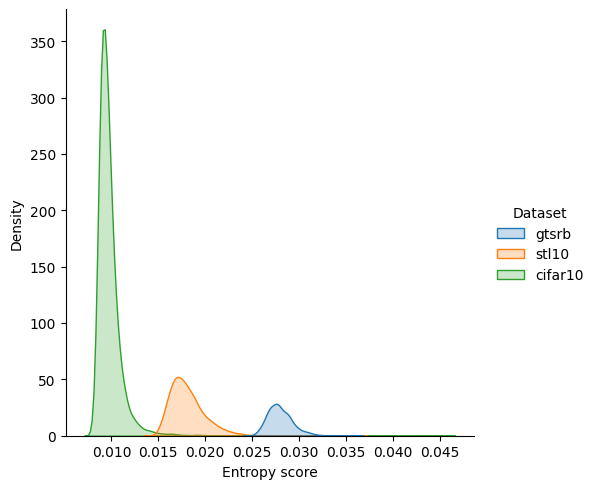

In [98]:
df_score_gtsrb_test = pd.DataFrame(score_gtsrb_test, columns=["Entropy score"])
df_score_stl10_valid = pd.DataFrame(score_stl10_valid, columns=["Entropy score"])
df_score_cifar10_valid = pd.DataFrame(score_cifar10_valid, columns=["Entropy score"])

df_score_gtsrb_test.insert(0, "Dataset", "")
df_score_gtsrb_test.loc[:, "Dataset"] = "gtsrb"

df_score_stl10_valid.insert(0, "Dataset", "")
df_score_stl10_valid.loc[:, "Dataset"] = "stl10"

df_score_cifar10_valid.insert(0, "Dataset", "")
df_score_cifar10_valid.loc[:, "Dataset"] = "cifar10"

df_h_z_valid_scores = pd.concat([df_score_gtsrb_test, df_score_stl10_valid, df_score_cifar10_valid]).reset_index(drop=True)


sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="kde", fill=True)
plt.show()

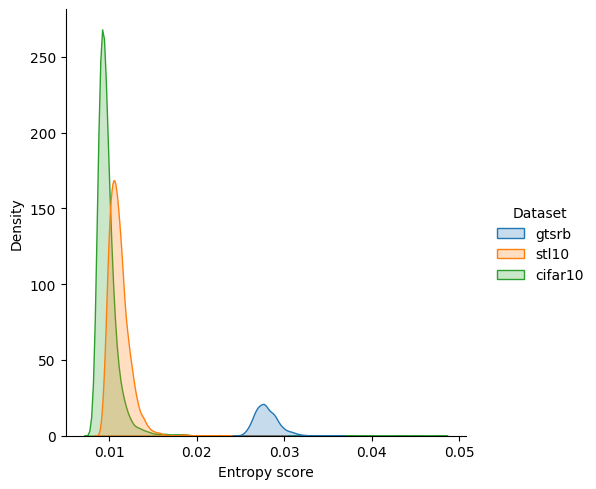

In [99]:
df_score_gtsrb_test = pd.DataFrame(score_gtsrb_test, columns=["Entropy score"])
df_score_stl10_test = pd.DataFrame(score_stl10_test, columns=["Entropy score"])
df_score_cifar10_test = pd.DataFrame(score_cifar10_test, columns=["Entropy score"])

df_score_gtsrb_test.insert(0, "Dataset", "")
df_score_gtsrb_test.loc[:, "Dataset"] = "gtsrb"

df_score_stl10_test.insert(0, "Dataset", "")
df_score_stl10_test.loc[:, "Dataset"] = "stl10"

df_score_cifar10_test.insert(0, "Dataset", "")
df_score_cifar10_test.loc[:, "Dataset"] = "cifar10"

df_h_z_test_scores = pd.concat([df_score_gtsrb_test, df_score_stl10_test, df_score_cifar10_test]).reset_index(drop=True)


sns.displot(df_h_z_test_scores, x="Entropy score", hue="Dataset", kind="kde", fill=True)
plt.show()